In [4]:
import numpy as np
from pydci import Model
from pydci.log import enable_log
from  pydci import SequentialMUDProblem
from pydci.examples.lotka_volterra import run_lv, lv_p1, lv_p2, lv_param_mins
import matplotlib.pyplot as plt
import importlib

enable_log()

[04/06/23 22:32:54] INFO     Logger initialized                                                           ]8;id=103264;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=356603;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py#35\35]8;;\

<loguru.logger handlers=[(id=2, level=20, sink=<RichHandler (NOTSET)>)]>

# Lotka-Volter Model

In [5]:
importlib.reload(SequentialMUDProblem)
importlib.reload(Model)

np.random.seed(12345)

lv1_true_param = lv_p1
x0 = [2, 4]
param_shifts = None  # {17: lv_p2}

lvm_model = Model.DynamicModel(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.2,
    solve_ts=0.1,
    sample_ts=1,
    diff=0.5,
    param_mins=lv_param_mins,
    param_shifts=param_shifts,
)

args = lvm_model.mud_args(5, num_samples=1000)

In [22]:
args['q_lam'].shape

(1000, 30)

## First iteration

In [6]:
args = lvm_model.mud_args(5, num_samples=1000)
lvm_model.x0, lvm_model.t0, args['data'].shape

[04/06/23 22:32:55] INFO     Drawing 1000 from uniform at:                                             ]8;id=774356;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=883394;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#250\250]8;;\
                                     loc: [0.55 0.2  0.25 0.05]                                                    
                                     scale: [1.1 0.4 0.5 0.1]                                                      

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.4s (2462.


(array([4.55636695, 1.02149546]), 4.081632653061225, (10, 1))

In [19]:
lvm_model.state_df

,ts,shift_idx,sample_flag,true_param_0,true_vals_0,true_vals_1,obs_vals_0,obs_vals_1
0,14.285714,0,True,1.1,8.834351,1.438826,8.909709,1.154721
1,14.386497,0,False,1.1,9.302869,1.499048,NaN,NaN
2,14.487280,0,False,1.1,9.770562,1.569184,NaN,NaN
3,14.588063,0,False,1.1,10.230567,1.650309,NaN,NaN
4,14.688845,0,False,1.1,10.674684,1.743566,NaN,NaN
...,...,...,...,...,...,...,...,...
142,28.596869,0,False,1.1,1.385717,2.456918,NaN,NaN
143,28.697652,0,False,1.1,1.404684,2.369250,NaN,NaN
144,28.798434,0,False,1.1,1.428846,2.285206,NaN,NaN
145,28.899217,0,False,1.1,1.458252,2.204738,NaN,NaN


### All data

In [7]:
importlib.reload(SequentialMUDProblem)

qoi_method = 'all'
best_method = 'closest'

seq_mud_prob = SequentialMUDProblem.SequentialMUDProblem(
    *[args[x] for x in ['samples', 'q_lam', 'data', 'std_dev']],
    max_nc=args['max_nc'], qoi_method=qoi_method, best_method=best_method)

# Solve
seq_mud_prob.solve()

seq_mud_prob.result

,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,0.824784,0.305882,0.593325,0.1089,0.927376,2.250453,0.072624,True,True,False,True,UPDATE


In [8]:
seq_mud_prob.mud_point

array([0.82478372, 0.30588213, 0.5933255 , 0.10890017])

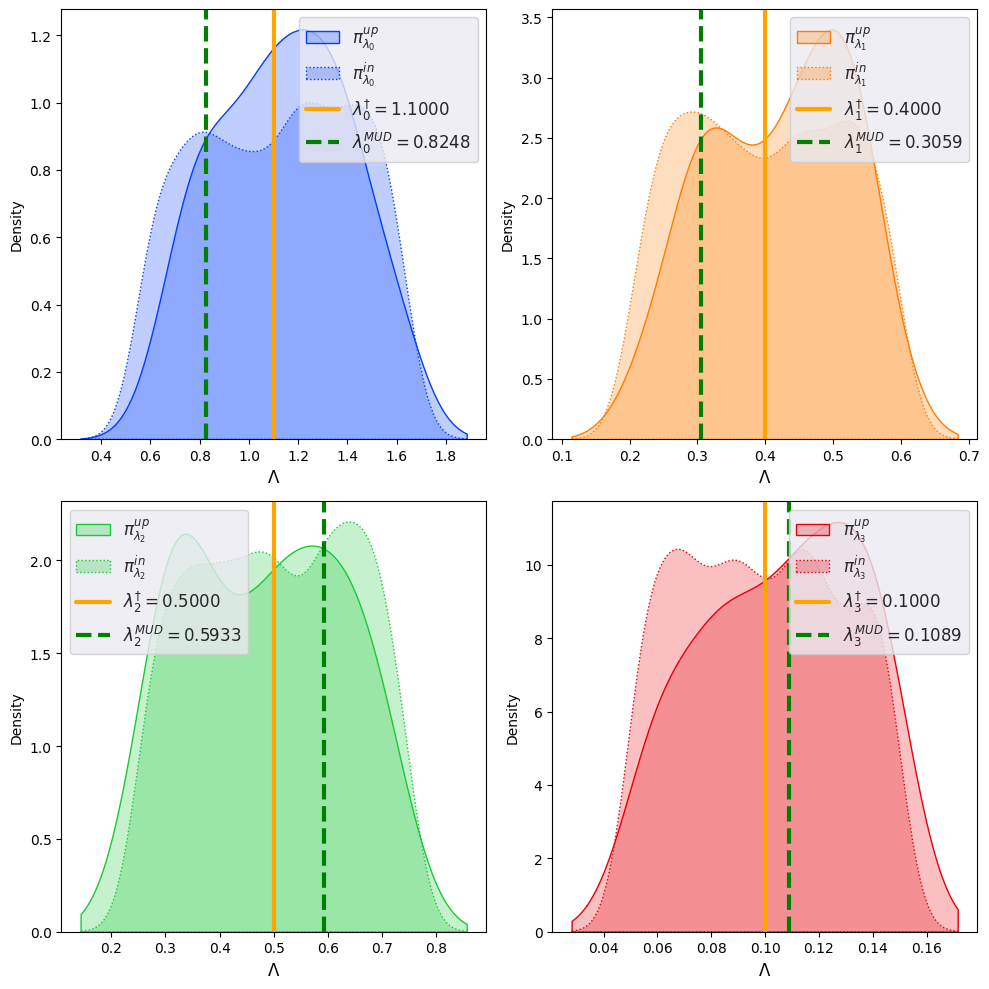

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

### Full state/results

In [7]:
seq_mud_prob.results

nc  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3       e_r        kl  \
0 0  1.0   0.928396   0.304639   0.450576   0.123107  0.993258  2.192209   
  1  2.0   0.796120   0.312239   0.562550   0.112705  0.537528  4.560920   
  2  3.0   1.149236   0.434757   0.623325   0.133766  0.493604  4.518462   
  3  4.0   1.149236   0.434757   0.623325   0.133766  0.502153  4.718305   

     predict_delta  within_thresh  closest  max_kl  min_kl  action  
0 0       0.006742           True     True   False    True  UPDATE  
  1       0.462472           True    False   False   False  UPDATE  
  2       0.506396          False    False   False   False    None  
  3       0.497847           True    False    True   False  UPDATE

In [8]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,...,q_lam_4,q_lam_5,q_lam_6,q_lam_7,q_lam_8,q_lam_9,q_pca_0,q_pca_1,q_pca_2,q_pca_3
0,1.0,23.426354,0.022059,2.978249e-30,1.350156e-28,3.162924e-27,0.710581,0.534338,0.285691,0.111634,...,0.168796,2.922147,0.086633,2.213087,0.062535,1.667096,-11.581647,23.943907,3.961808,4.389224
1,1.0,18.064722,0.002093,0.000000e+00,0.000000e+00,0.000000e+00,1.643399,0.215450,0.381225,0.140231,...,6.847935,7.116063,4.579435,11.623056,1.676406,11.938977,68.229911,31.979267,-1.886250,11.331302
2,1.0,46.413416,0.023105,1.617166e-05,6.999151e-04,3.248545e-02,1.374766,0.524072,0.490251,0.090738,...,1.260183,1.940406,2.147637,1.367442,4.565577,1.112099,-4.497402,2.410613,-1.015259,1.247506
3,1.0,27.988828,0.005707,1.526809e-274,2.675095e-272,7.487277e-271,1.394563,0.258020,0.250521,0.119704,...,4.076511,4.922473,3.882176,6.291484,2.643042,7.287062,35.484256,18.580758,0.513972,7.860726
4,1.0,29.998073,0.004819,0.000000e+00,0.000000e+00,0.000000e+00,1.419107,0.362458,0.424240,0.052033,...,4.966167,2.100644,10.073740,1.996829,18.534926,2.752676,41.363929,-46.681982,-10.241898,-12.640172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,21.965513,0.016031,6.363228e-61,3.969248e-59,8.718657e-58,0.574422,0.573696,0.395852,0.120768,...,0.192884,2.043825,0.128321,1.390697,0.117471,0.942408,-16.594470,17.574854,3.870762,6.795196
996,1.0,16.140440,0.023485,3.577781e-08,1.523444e-06,2.458906e-05,1.622657,0.599266,0.430129,0.136991,...,0.976682,2.397464,1.431266,1.816614,2.728581,1.545471,-5.696841,10.948827,0.957188,3.369601
997,1.0,21.878528,0.012144,2.078196e-80,1.711229e-78,3.743916e-77,0.605841,0.556663,0.576063,0.052855,...,0.381757,1.296547,0.403819,0.735293,0.544556,0.418829,-19.107923,11.195905,2.669377,6.524899
998,1.0,44.333740,0.021906,4.668713e-02,2.131229e+00,9.448537e+01,1.115669,0.418016,0.545962,0.110479,...,1.618609,1.955484,2.500012,1.401713,4.555443,1.177930,-2.071400,1.495647,-0.011628,0.262548


In [9]:
seq_mud_prob.search_states

,pi_obs_0_nc=1,pi_pr_0_nc=1,ratio_0_nc=1,pi_up_0_nc=1,pi_obs_0_nc=2,pi_pr_0_nc=2,ratio_0_nc=2,pi_up_0_nc=2,pi_obs_0_nc=3,pi_pr_0_nc=3,ratio_0_nc=3,pi_up_0_nc=3,pi_obs_0_nc=4,pi_pr_0_nc=4,ratio_0_nc=4,pi_up_0_nc=4
0,1.017090e-59,0.009860,1.031549e-57,3.610931e-56,8.316007e-190,0.000189,4.393167e-186,1.537826e-184,9.311642e-195,0.000066,1.420059e-190,4.970909e-189,3.489914e-210,0.000018,1.917483e-205,6.712136e-204
1,6.727546e-32,0.022905,2.937214e-30,1.519809e-28,2.497332e-35,0.000641,3.893236e-32,2.014486e-30,9.582914e-36,0.000188,5.105989e-32,2.642003e-30,1.424393e-39,0.000026,5.440860e-35,2.815276e-33
2,5.582945e-92,0.011537,4.839267e-90,9.103071e-89,6.882749e-117,0.000472,1.458614e-113,2.743776e-112,1.989669e-118,0.000093,2.141864e-114,4.029027e-113,1.459375e-121,0.000013,1.118138e-116,2.103311e-115
3,6.172922e-03,0.018153,3.400408e-01,1.320512e+01,6.072993e-12,0.000494,1.229927e-08,4.776289e-07,3.961188e-15,0.000029,1.364880e-10,5.300363e-09,1.442475e-16,0.000009,1.638518e-11,6.363008e-10
4,5.617587e-04,0.022806,2.463164e-02,1.365279e+00,1.806565e-04,0.000661,2.732334e-01,1.514474e+01,5.911098e-05,0.000143,4.119782e-01,2.283506e+01,1.577212e-05,0.000042,3.750617e-01,2.078886e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.264669e-02,0.018531,1.222123e+00,6.326939e+01,6.451700e-03,0.000576,1.120241e+01,5.799493e+02,1.733177e-03,0.000145,1.192499e+01,6.173575e+02,6.266232e-04,0.000034,1.831252e+01,9.480400e+02
996,4.805138e-06,0.016741,2.870235e-04,5.998200e-03,7.351363e-08,0.000505,1.456742e-04,3.044292e-03,1.281494e-09,0.000049,2.600482e-05,5.434473e-04,1.372159e-10,0.000015,8.872094e-06,1.854085e-04
997,1.058520e-07,0.016196,6.535499e-06,3.469881e-04,6.963975e-19,0.000441,1.578831e-15,8.382462e-14,1.203433e-19,0.000135,8.938161e-16,4.745523e-14,1.953682e-23,0.000010,1.909236e-18,1.013667e-16
998,0.000000e+00,0.001232,0.000000e+00,0.000000e+00,0.000000e+00,0.000008,0.000000e+00,0.000000e+00,0.000000e+00,0.000004,0.000000e+00,0.000000e+00,0.000000e+00,0.000001,0.000000e+00,0.000000e+00


## Second iteration

Have to call `update_iteration` to feed in new samples, data and push_forwards. Note how we re-sample from updated distribution using `sample_update()` to get new set of samples to start from current system time.

In [10]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(10, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])
seq_mud_prob.solve()
seq_mud_prob.result

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.6s (1850.


,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,1.39856,0.512822,0.354764,0.067204,1.467346,6.675802,0.467346,True,True,True,True,UPDATE


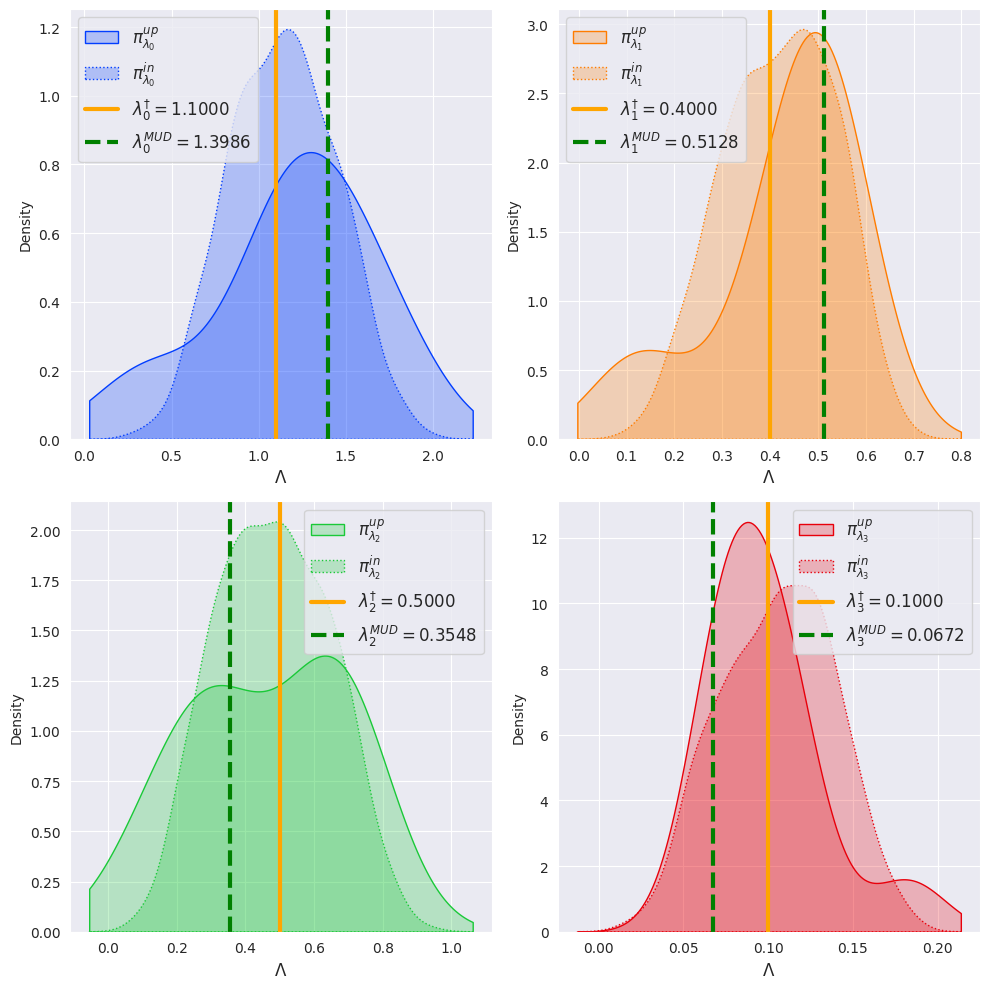

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

## Third iteration

In [12]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(15, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

# Update data 
seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])

# Solve

# Get result

seq_mud_prob.solve()

seq_mud_prob.result

on 223: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
          warnings.warn(warning_msg, ODEintWarning)


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.4s (2514.


,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,1.034392,0.357356,0.543591,0.103152,1.003457,2.090707,0.003457,True,True,False,True,UPDATE


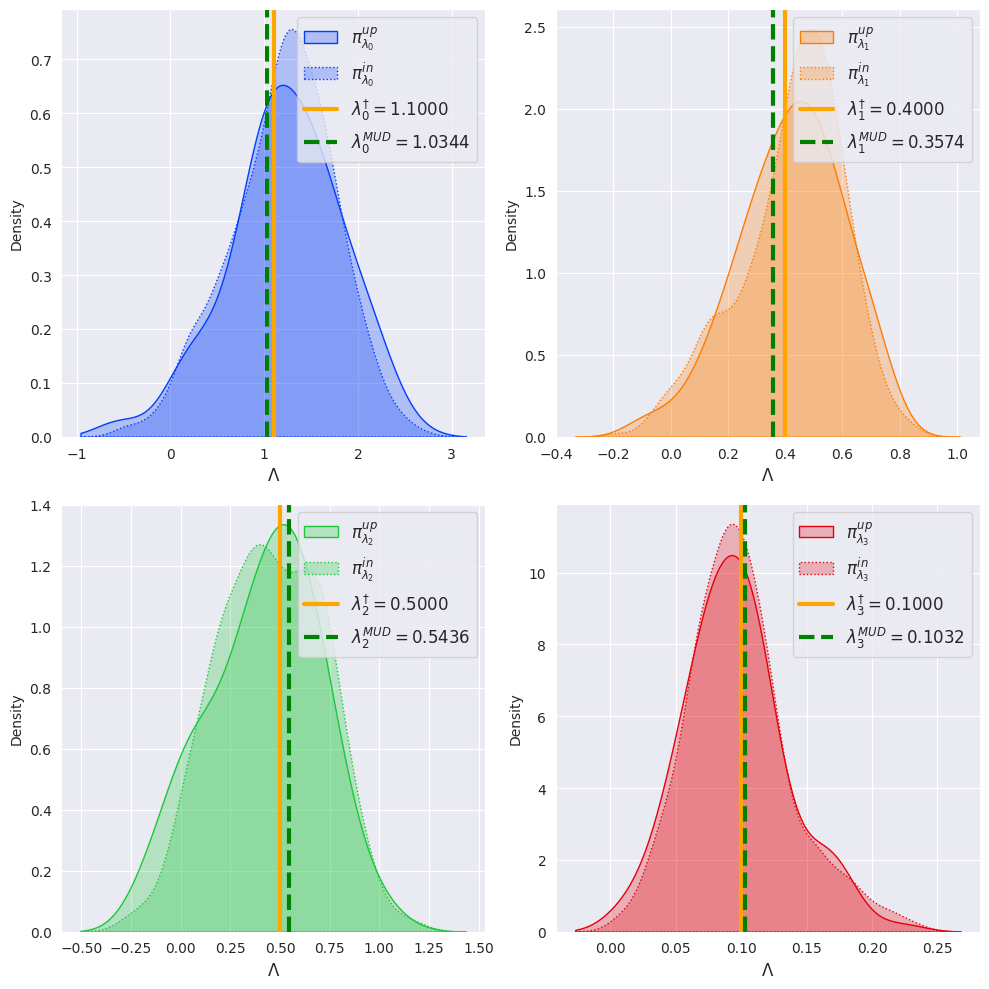

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

In [14]:
## Fourth Iteration

In [15]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(29, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

# Update data 
seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])

# Solve
seq_mud_prob.solve()

# Get result
seq_mud_prob.result

on 34: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
         warnings.warn(warning_msg, ODEintWarning)


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.9s (1053.


/opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0,1.0,1.555119,0.5689,0.308218,0.048513,1.247737,5.424982,0.247737,True,True,True,True,UPDATE


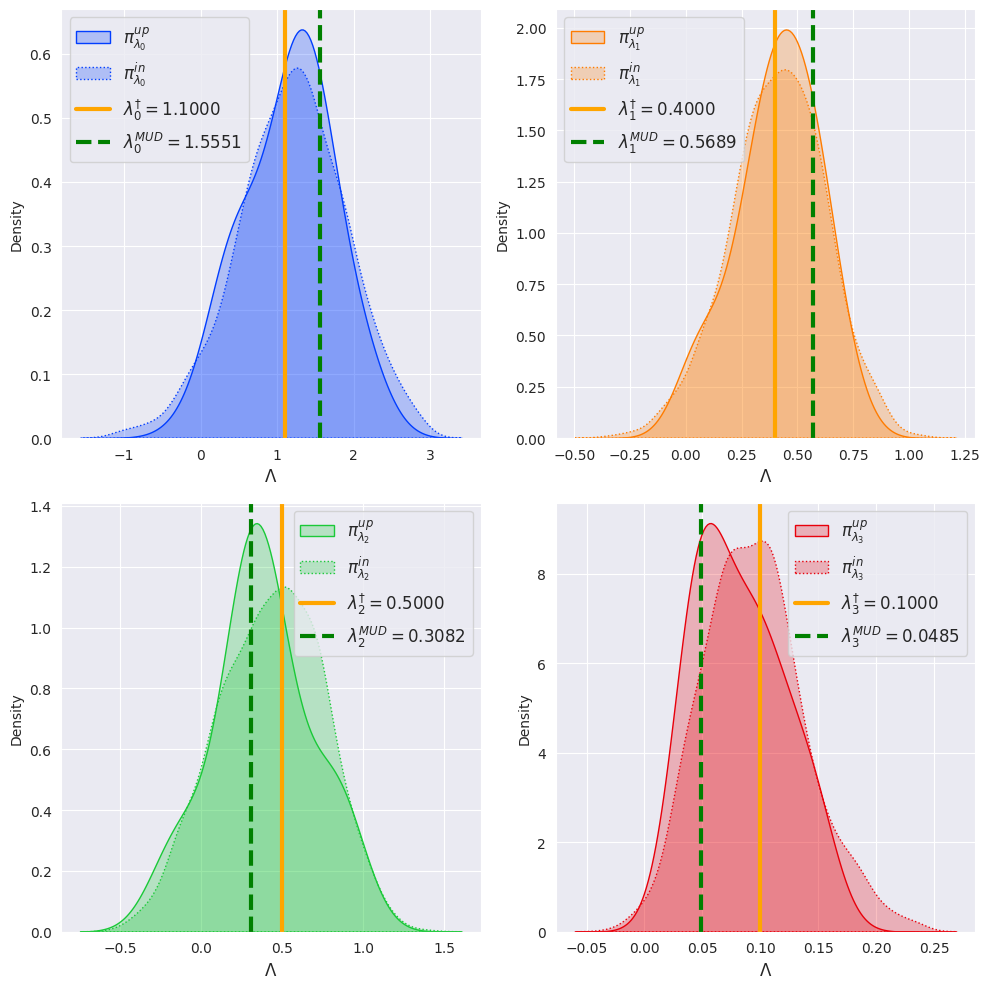

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])